# Image Captioning

## Assignment Details

**Group:** DL Assignment Group 21<br>
**Group Members:**
* Sanket Walke - 2019AP04052
* Harish Pasupuleti - 2019AP04028
* Chitral Verma - 2019AP04012

#### Import the required libraries and the dataset 

In [ ]:
import pandas as pd
import numpy as np
import re
import os.path
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
import matplotlib.pyplot as plt
import glob
from PIL import Image
import string
import time
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Concatenate,Add
pd.set_option('display.max_colwidth', None)

#####Check GPU availability

In [ ]:
print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("GPU is", "available" if tf.config.list_physical_devices("GPU") else "NOT AVAILABLE")
print("GPU device name:", tf.test.gpu_device_name())

Version:  2.5.0
Eager mode:  True
GPU is available
GPU device name: /device:GPU:0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##### Read	the	pickle	file

In [ ]:
pkl_df = pd.read_pickle("drive/MyDrive/dataset/set_1.pkl")

In [ ]:
pkl_list=[]
for d in pkl_df:
  pkl_list.append(re.split('#|\t',d,maxsplit=2))

In [ ]:
mdf = pd.DataFrame(pkl_list,columns =['ImageName', 'id','Caption'])

In [ ]:
del(pkl_df)

In [ ]:
mdf.head()

,ImageName,id,Caption
0,2089122314_40d5739aef.jpg,3,"A fluffy , tri-colored dog be run down a road with a paper in its mouth ."
1,1295671216_cde1b9c9d1.jpg,0,"A crowd of person be stand together on a sidewalk , while one man be take a picture ."
2,3183195185_cd0ff994a1.jpg,4,"The man and boy sit on the ground , next to a rocky wall ."
3,2949353587_64c54e9589.jpg,1,A brown dog be play with a white fluffy stuff animal .
4,361092202_3d70144ebd.jpg,2,A man hike with a large backpack and two pole near a collection of pointy white rock .


In [ ]:
mdf = mdf.groupby(['ImageName']).sum()
mdf.drop(columns=['id'],inplace=True)
mdf.reset_index(inplace=True)

In [ ]:
mdf.head()

,ImageName,Caption
0,1000268201_693b08cb0e.jpg,A girl go into a wooden building .A child in a pink dress be climb up a set of stair in an entry way .A little girl climb into a wooden playhouse .A little girl climb the stair to her playhouse .A little girl in a pink dress go into a wooden cabin .
1,1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog play with each other on a road .A black dog and a white dog with brown spot be stare at each other in a street .Two dog on pavement move toward each other .
2,1002674143_1b742ab4b8.jpg,There be a girl with pigtail sit in front of a rainbow paint .A little girl be sit in front of a large painted rainbow .
3,1003163366_44323f5815.jpg,A man lay on a bench while his dog sit by him .A man lay on a bench to which a white dog be also tie .A shirtless man lie on a park bench with his dog .man lay on bench hold leash of dog sit on ground
4,1007129816_e794419615.jpg,A man wear an orange hat and glasses .A man in an orange hat star at something .A man with pierced ear be wear glasses and an orange hat .


##### Image	dataset

In [ ]:
if not os.path.isdir('Flicker8k_Dataset'):
  !unzip -q drive/MyDrive/dataset/Image_captioning_Dataset.zip

In [ ]:
image_dict = {}
for filename in glob.glob('Flicker8k_Dataset/*.jpg'):
    img=load_img(filename,target_size=(224,224))
    image_dict[filename]=img

In [ ]:
dic={}
for i in mdf.ImageName:
  for j in image_dict:
    if i in j:
      dic[i]=image_dict[j]

In [ ]:
df_test = pd.DataFrame.from_dict(dic,orient='index',columns=['Image'])
df_test.reset_index(inplace=True)
df_test.rename(columns={'index':'ImageName'},inplace=True)

In [ ]:
del(image_dict)

In [ ]:
del(dic)

In [ ]:
main_df = pd.merge(mdf,df_test,on=['ImageName'])

In [ ]:
main_df.head()

,ImageName,Caption,Image
0,1000268201_693b08cb0e.jpg,A girl go into a wooden building .A child in a pink dress be climb up a set of stair in an entry way .A little girl climb into a wooden playhouse .A little girl climb the stair to her playhouse .A little girl in a pink dress go into a wooden cabin .,<PIL.Image.Image image mode=RGB size=224x224 at 0x7F5838EB0B90>
1,1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog play with each other on a road .A black dog and a white dog with brown spot be stare at each other in a street .Two dog on pavement move toward each other .,<PIL.Image.Image image mode=RGB size=224x224 at 0x7F5838D2CAD0>
2,1002674143_1b742ab4b8.jpg,There be a girl with pigtail sit in front of a rainbow paint .A little girl be sit in front of a large painted rainbow .,<PIL.Image.Image image mode=RGB size=224x224 at 0x7F5838E53450>
3,1003163366_44323f5815.jpg,A man lay on a bench while his dog sit by him .A man lay on a bench to which a white dog be also tie .A shirtless man lie on a park bench with his dog .man lay on bench hold leash of dog sit on ground,<PIL.Image.Image image mode=RGB size=224x224 at 0x7F5838E8BA10>
4,1007129816_e794419615.jpg,A man wear an orange hat and glasses .A man in an orange hat star at something .A man with pierced ear be wear glasses and an orange hat .,<PIL.Image.Image image mode=RGB size=224x224 at 0x7F5838DEFD10>


In [ ]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8032 entries, 0 to 8031
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ImageName  8032 non-null   object
 1   Caption    8032 non-null   object
 2   Image      8032 non-null   object
dtypes: object(3)
memory usage: 251.0+ KB


##### Plot images and their captions

Caption: ['A girl go into a wooden building ', 'A child in a pink dress be climb up a set of stair in an entry way ', 'A little girl climb into a wooden playhouse ', 'A little girl climb the stair to her playhouse ', 'A little girl in a pink dress go into a wooden cabin ']


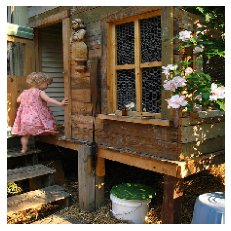

-------------------------------
Caption: ['A black dog and a tri-colored dog play with each other on a road ', 'A black dog and a white dog with brown spot be stare at each other in a street ', 'Two dog on pavement move toward each other ']


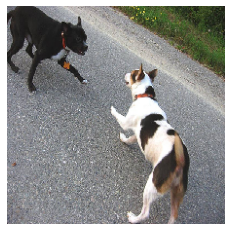

-------------------------------
Caption: ['There be a girl with pigtail sit in front of a rainbow paint ', 'A little girl be sit in front of a large painted rainbow ']


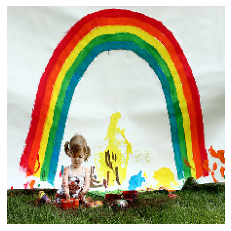

-------------------------------


In [ ]:
for i in range(len(main_df.head(3))):
  print("Caption: "+ str(main_df['Caption'][i].split(".")[:-1]))
  plt.imshow(main_df['Image'][i])
  plt.axis(False)
  plt.show()
  print("-------------------------------")

##### Bring	the	train	and	test data in	the	required format

In [ ]:
image = main_df['Image']
for i in range(len(image)):
  image[i]=np.asarray(image[i])

In [ ]:
from sklearn.model_selection import train_test_split
# have to use 50% size, as colab session crashes if we increase the train size
train, test = train_test_split(main_df, test_size=0.5)

In [ ]:
caption_dict={}
for i in range(len(train)):
  caption_dict[train.ImageName.values[i]]=["START "+sent.strip()+" END" for sent in train.Caption.values[i].lower().split(".")][:-1]

In [ ]:
caption_dict.get('1000268201_693b08cb0e.jpg')

In [ ]:
count_words = {}
count=1
for k,vv in caption_dict.items():
    for v in vv:
        for word in v.split():
            if word not in count_words:
              count_words[word] = count
              count +=1

In [ ]:
len(count_words)

4452

In [ ]:
for k,vv in caption_dict.items():
    for v in vv:
        encode=[]
        for word in v.split():
          encode.append(count_words[word])
        caption_dict[k][vv.index(v)]=encode

In [ ]:
caption_dict.get('1000268201_693b08cb0e.jpg')

In [ ]:
del(encode)

##### Pretrained	Resnet-50 model

In [ ]:
from tensorflow.keras.applications import ResNet50
resnet_model = ResNet50()

In [ ]:
image_model = Model(inputs=resnet_model.input, outputs=resnet_model.layers[-2].output)

In [ ]:
image_feat = {}
for im in range(len(train)):
  img = train['Image'].values[im].reshape(1,224,224,3)
  pred = image_model.predict(img).reshape(2048,)
  image_feat[train.ImageName.values[im]] = pred

In [ ]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
MAX_LEN = 0
for k, vv in caption_dict.items():
    for v in vv:
        if len(v) > MAX_LEN:
            MAX_LEN = len(v)

In [ ]:
MAX_LEN

49

In [ ]:
VOCAB_SIZE = len(count_words)

def generator(photo, caption):
    n_samples = 0
    
    X = []
    y_in = []
    y_out = []
    
    for k, vv in caption.items():
        for v in vv:
            for i in range(1, len(v)):
              try:
                X.append(photo[k])

                in_seq= [v[:i]]
                out_seq = v[i]

                in_seq = pad_sequences(in_seq, maxlen=MAX_LEN, padding='post', truncating='post')[0]
                out_seq = to_categorical([out_seq], num_classes=VOCAB_SIZE+1)[0]

                y_in.append(in_seq)
                y_out.append(out_seq)
              except:
                pass
            
    return X, y_in, y_out

In [ ]:
X, y_in, y_out = generator(image_feat, caption_dict)

In [ ]:
X_img = np.asarray(X)
del(X)
X_cap = np.asarray(y_in)
del(y_in)
Y_out = np.asarray(y_out)
del(y_out)

In [ ]:
X_img.shape,X_cap.shape,Y_out.shape

((141506, 2048), (141506, 49), (141506, 4453))

### Model Building & Compilation

In [ ]:
embedding_size = 128
max_len = MAX_LEN
vocab_size = len(count_words) + 1

image_model1 = Sequential()

image_model1.add(Dense(embedding_size, input_shape=(2048,), activation='relu'))
image_model1.add(Dropout(0.2))
image_model1.add(RepeatVector(max_len))

#image_model1.summary()

language_model = Sequential()

language_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=max_len))
language_model.add(LSTM(128, kernel_regularizer=tf.keras.regularizers.l2(l2=0.00001), return_sequences=True))
language_model.add(Dropout(0.2))
#language_model.add(LSTM(128, kernel_regularizer=tf.keras.regularizers.l2(l2=0.00001), return_sequences=True))
#language_model.add(Dropout(0.2))
language_model.add(TimeDistributed(Dense(embedding_size)))

#language_model.summary()

conca = Concatenate()([image_model1.output, language_model.output])
x = LSTM(128, kernel_regularizer=tf.keras.regularizers.l2(l2=0.00001), return_sequences=True)(conca)
x = LSTM(128, kernel_regularizer=tf.keras.regularizers.l2(l2=0.00001), return_sequences=False)(x)
#x = Dropout(0.2)(x)

out = Dense(vocab_size,activation='softmax')(x)
model = Model(inputs=[image_model1.input, language_model.input], outputs = out)

model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss=tf.losses.categorical_crossentropy, metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
embedding_input (InputLayer)    [(None, 49)]         0                                            
__________________________________________________________________________________________________
dense_input (InputLayer)        [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 49, 128)      569984      embedding_input[0][0]            
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          262272      dense_input[0][0]                
____________________________________________________________________________________________

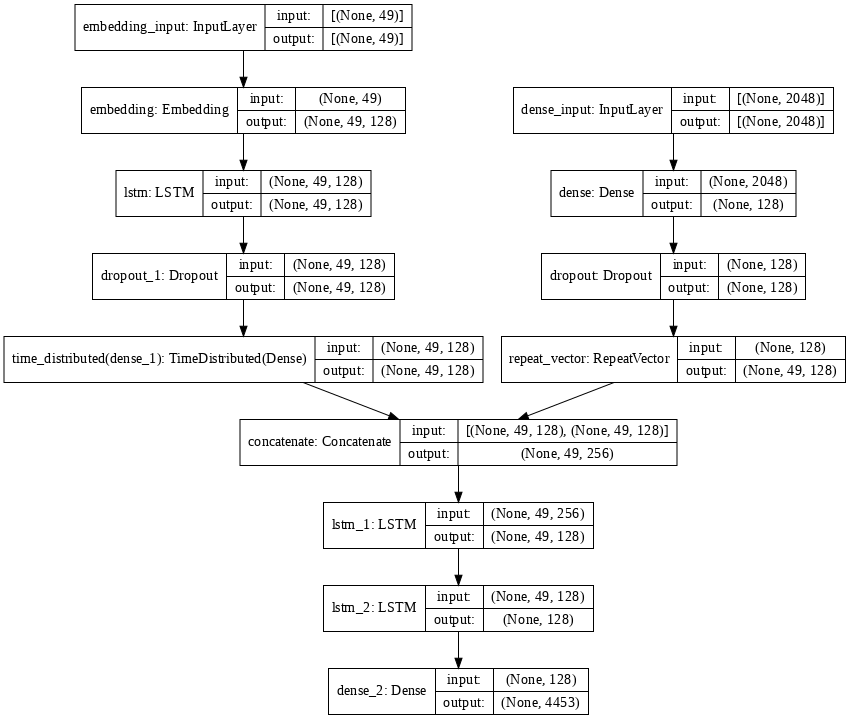

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes=True,dpi=72)

###Model Training

In [ ]:
start = time.time()
history = model.fit([X_img, X_cap], Y_out, batch_size=720, epochs=30, validation_split=0.1, use_multiprocessing=True)
end = time.time()

Epoch 1/30
177/177 [==============================] - 20s 80ms/step - loss: 5.4836 - accuracy: 0.1421 - val_loss: 5.2235 - val_accuracy: 0.1438
Epoch 2/30
177/177 [==============================] - 13s 74ms/step - loss: 5.2164 - accuracy: 0.1434 - val_loss: 5.2362 - val_accuracy: 0.1438
Epoch 3/30
177/177 [==============================] - 13s 75ms/step - loss: 5.2111 - accuracy: 0.1434 - val_loss: 5.2353 - val_accuracy: 0.1438
Epoch 4/30
177/177 [==============================] - 13s 74ms/step - loss: 5.1654 - accuracy: 0.1434 - val_loss: 5.1544 - val_accuracy: 0.1438
Epoch 5/30
177/177 [==============================] - 13s 74ms/step - loss: 5.1058 - accuracy: 0.1434 - val_loss: 5.1239 - val_accuracy: 0.1438
Epoch 6/30
177/177 [==============================] - 13s 75ms/step - loss: 5.0567 - accuracy: 0.1434 - val_loss: 5.0300 - val_accuracy: 0.1459
Epoch 7/30
177/177 [==============================] - 13s 75ms/step - loss: 4.9639 - accuracy: 0.1442 - val_loss: 5.1038 - val_accuracy:

In [ ]:
# Print the total time taken for training
print("Total time taken for training: ", (end - start)/60, "mins")

Total time taken for training:  6.784451468785604 mins


#### Plot the loss and accuracy history graphs for both train and validation set.

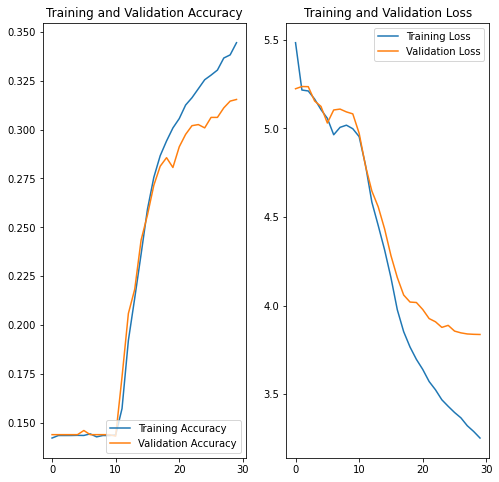

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(history.epoch))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
inv_dict = {v:k for k, v in count_words.items()}

In [ ]:
def getImage(x):
    test_img = np.reshape(x, (1,224,224,3))
    return test_img

###Model Evaluation

#####Take	a	random	image	from	google	and	generate	caption	for	that	image

In [ ]:
img_name = ['dog.jpg','baby_swim.jpg','boy_cycle.jpg','snowshoe.jpg']

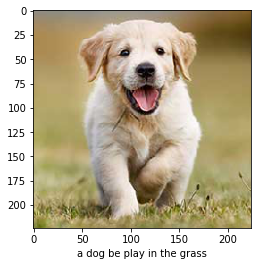

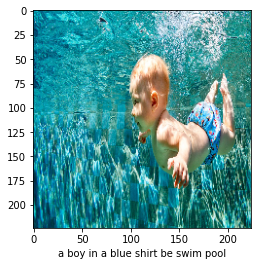

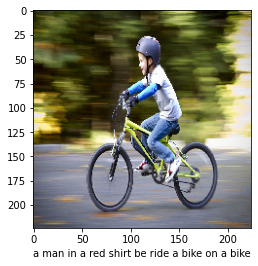

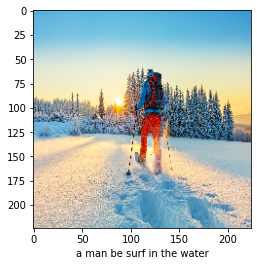

In [ ]:
for iname in img_name:
    testImg = load_img(iname,target_size=(224,224,3))
    test_pred = image_model.predict(getImage(testImg)).reshape(1,2048)
    text_inp = ['START']

    count = 0
    caption = ''
    while count < 25:
                count += 1

                encoded = []
                for i in text_inp:
                    encoded.append(count_words[i])

                encoded = [encoded]

                encoded = pad_sequences(encoded, padding='post', truncating='post', maxlen=MAX_LEN)


                prediction = np.argmax(model.predict([test_pred, encoded]))

                sampled_word = inv_dict[prediction]

                caption = caption + ' ' + sampled_word
                    
                if sampled_word == 'END':
                    break

                text_inp.append(sampled_word)
                
    plt.figure()
    plt.imshow(testImg)
    plt.xlabel(caption.replace("END","").strip())

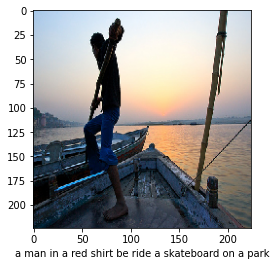

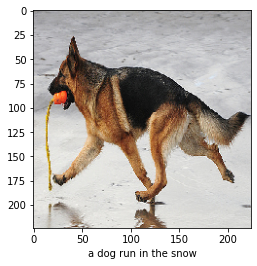

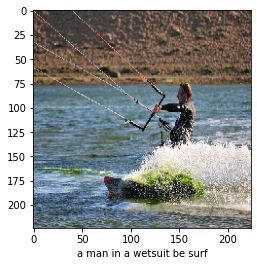

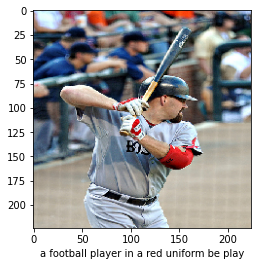

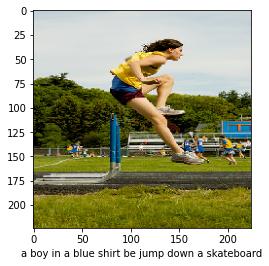

In [ ]:
for i in range(5):
    test_image=test['Image'].values[i]
    test_pred = image_model.predict(getImage(test_image)).reshape(1,2048)
    text_inp = ['START']

    count = 0
    caption = ''
    while count < 25:
            count += 1

            encoded = []
            for i in text_inp:
                encoded.append(count_words[i])

            encoded = [encoded]

            encoded = pad_sequences(encoded, padding='post', truncating='post', maxlen=MAX_LEN)


            prediction = np.argmax(model.predict([test_pred, encoded]))

            sampled_word = inv_dict[prediction]

            caption = caption + ' ' + sampled_word
                
            if sampled_word == 'END':
                break

            text_inp.append(sampled_word)

    plt.figure()
    plt.imshow(test_image)
    plt.xlabel(caption.replace("END","").strip())